In [1]:
# import some necessary functions for plotting as well as the diffusion_map class from pydiffmap.
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.sparse import linalg
%matplotlib inline

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [3]:
from pyspark.mllib.linalg import Matrices
from pyspark.mllib.linalg.distributed import BlockMatrix
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg.distributed import DenseMatrix
from pyspark.mllib.linalg import SparseMatrix
from math import exp
import math

In [4]:
import sparkDiffusionMap

In [5]:
from sparkDiffusionMap.sparkDiffusionMap import distributed_diffusion_map

Diffusion mapping is a form of dimensional reduction, where instead of a traditional distance metric used for reduction the probability of transition between different points. Ideally this method allows us to retain information about nonlinear structures in a multidimensional dataset while still reducing them to something more human or computationally managable. For this example we are going to use a 3d to 2d dimensional reduction, but the method applies from any n to m reduction, provided n>m.

In [6]:
def data_plot(data, dim=3, scatter_kwargs=None, show=True):
        #This function creates a plot of the original data to be used for debugging
        #Paramaters
        #data: The object to be plotted
        #n_evec: the number of eigenvectors
        #dim: the number of dimensions of the original data set
        #x: an m dimensional point 
        #y: an m dimensional point
        #scatter_kwargs: a dictionary of arguments for the scatter 
        #show: To show it
        #return a plot of the original data set
        
        if scatter_kwargs is None:
            scatter_kwargs = {}
        fig = plt.figure(figsize=(6, 6))
        data = np.asarray(data)
       
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=data[:, 2], **scatter_kwargs)
        ax.set_title('Data coloured with first DC.')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.axis('tight')
        if show:
            plt.show()
        return fig

In [7]:
length_phi = 15   #length of swiss roll in angular direction
length_Z = 15     #length of swiss roll in z direction
sigma = 0.1       #noise strength
m = 10000         #number of samples
m = 1000         #number of samples

# create dataset
phi = length_phi*np.random.rand(m)
xi = np.random.rand(m)
Z = length_Z*np.random.rand(m)
X = 1./6*(phi + sigma*xi)*np.sin(phi)
Y = 1./6*(phi + sigma*xi)*np.cos(phi)

cylinder = np.array([X, Y, Z]).transpose()

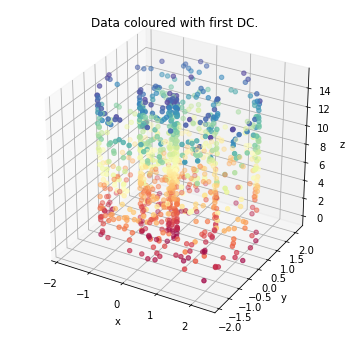

In [8]:
data_plot(cylinder, dim=3,  scatter_kwargs = {'cmap': 'Spectral'})
plt.show()

In this plot particles want to transition along the x and y axis, but not the z axis. So ideally our diffusion map should group the points favoring those close on the x and y axis, but not so much on the z axis. We colored the data set to illustruate these differences

In [9]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)
rows = sc.parallelize(cylinder).map(lambda x: [np.float64(i).item() for i in x]).collect()
y = distributed_diffusion_map.create_map(steps=5,epsilon=2)
y.make_similarity_matrix_2(rows, sc)
sparse = y.make_d_matrix(sc)
y.normalize_matrix(sc)
y.calculate_eigenvalues_v2()
y.get_transformed_data()

array([[-0.00039718,  0.00244857],
       [-0.00089816, -0.00313001],
       [ 0.00108678, -0.00330738],
       ...,
       [-0.0002948 ,  0.00301978],
       [ 0.00094122, -0.00168887],
       [ 0.00110159, -0.0034872 ]])

In [10]:
def embedding_plot(dmap=None, dim=2, scatter_kwargs=None, show=True):
    #embedding_plot
    #This function creates a scatter plot of the diffusion map data using the provided number of dimensions
    #and scatter args
    #Paramaters
    #dmap: The diffusion map to graph
    #dim: the number of dimensions in the diffusion map 
    #scatter_kwargs: a dictionary of arguments for the scatter 
    #show: To show it
    #return The scatter figure

    if scatter_kwargs is None:
        scatter_kwargs = {}
    fig = plt.figure(figsize=(6, 6))
    if (dim == 2):
        plt.scatter(dmap[:, 0], dmap[:, 1], **scatter_kwargs)
        plt.plot(dmap[:, 0], dmap[:, 1], color='none')
        plt.title('Embedding given by first two DCs.')
        plt.xlabel(r'$\psi_1$')
        plt.ylabel(r'$\psi_2$')
    elif (dim == 3):
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(dmap[:, 0], dmap[:, 1], dmap[:, 2], **scatter_kwargs)
        ax.set_title('Embedding given by first three DCs.')
        ax.set_xlabel(r'$\psi_1$')
        ax.set_ylabel(r'$\psi_2$')
        ax.set_zlabel(r'$\psi_3$')
    plt.axis('tight')
    plt.autoscale(enable=True, axis="both")
        #This is goofy, but at very small values the autoscaling on the scatter plot fails.
        #So we have to calculate the limits by hand.
    nmax = np.amax(dmap)*1.25
    nmin = np.amin(dmap)*1.25
    plt.xlim(( nmin , nmax))
    plt.ylim(( nmin, nmax))

    if show:        
        plt.show()
    return fig

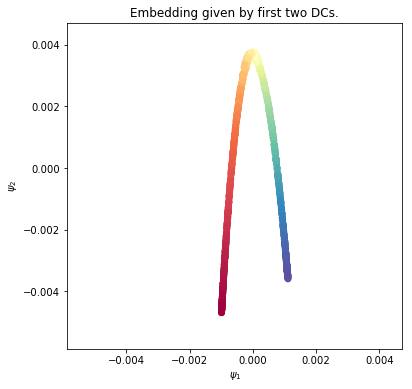

In [11]:
embedding_plot(dmap=y.dmap, scatter_kwargs = {'c': y.dmap[:,0], 'cmap': 'Spectral'}, show=False)
plt.show()

Here we can see that the diffusion mapping has grouped our data in a rough parablola, but also keeping the point likely to transition close together.